In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import re, string, unicodedata
from string import punctuation
from termcolor import colored
from collections import Counter


from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split


import keras
import tensorflow as tf
from keras.preprocessing import text, sequence
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.text import Tokenizer

import nltk
from nltk.corpus import stopwords
from textblob import Word
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk import pos_tag
from nltk.corpus import wordnet


from warnings import filterwarnings
filterwarnings('ignore')

from sklearn import set_config
set_config(print_changed_only = False)

print(colored("\nLIBRARIES WERE SUCCESFULLY IMPORTED...", "green"))



LIBRARIES WERE SUCCESFULLY IMPORTED...


[nltk_data] Downloading package stopwords to /home/aniket/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/aniket/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/aniket/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [4]:
tf.keras.backend.clear_session()
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


2023-05-08 18:42:30.957134: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-08 18:42:31.013416: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-08 18:42:31.013642: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [5]:
true_news = pd.read_csv("True.csv")
fake_news = pd.read_csv("Fake.csv")

true_news['text'].size, fake_news['text'].size

#print(colored("\nDATASETS WERE SUCCESFULLY LOADED...", "green"))

(21417, 23481)

In [6]:
news_l = true_news['text'].values.tolist()
news_l_title = true_news['title'].values.tolist()
fake_n = fake_news['text'].values.tolist()
fake_n_title = fake_news['title'].values.tolist()
news_l_s = true_news['subject'].values.tolist()
fake_l_s = fake_news['subject'].values.tolist()


for i in range (len(news_l)):
    news_l[i] = news_l_title[i] +": " + news_l[i]

for i in range (len(fake_n)):
    fake_n[i] = fake_n_title[i] +": " + fake_n[i]
    news_l_title.append(fake_n_title[i])
    news_l_s.append(fake_l_s[i])
    
n_class = list()
for i in range (len(news_l)):
    n_class.append(1)

for i in range (len(fake_n)):
    n_class.append(0)
    
for item in fake_n:
    news_l.append(item)
    
   
print(len(news_l))
print(len(n_class)) 





data = {'title': news_l_title, 'text': news_l, 'subject': news_l_s , 'news_class': n_class}
news = pd.DataFrame(data)
news.columns, news.size

44898
44898


(Index(['title', 'text', 'subject', 'news_class'], dtype='object'), 179592)

In [7]:
news.head()

title   
0  As U.S. budget fight looms, Republicans flip t...  \
1  U.S. military to accept transgender recruits o...   
2  Senior U.S. Republican senator: 'Let Mr. Muell...   
3  FBI Russia probe helped by Australian diplomat...   
4  Trump wants Postal Service to charge 'much mor...   

                                                text       subject  news_class  
0  As U.S. budget fight looms, Republicans flip t...  politicsNews           1  
1  U.S. military to accept transgender recruits o...  politicsNews           1  
2  Senior U.S. Republican senator: 'Let Mr. Muell...  politicsNews           1  
3  FBI Russia probe helped by Australian diplomat...  politicsNews           1  
4  Trump wants Postal Service to charge 'much mor...  politicsNews           1

In [8]:
news.tail()

title   
44893  McPain: John McCain Furious That Iran Treated ...  \
44894  JUSTICE? Yahoo Settles E-mail Privacy Class-ac...   
44895  Sunnistan: US and Allied ‘Safe Zone’ Plan to T...   
44896  How to Blow $700 Million: Al Jazeera America F...   
44897  10 U.S. Navy Sailors Held by Iranian Military ...   

                                                    text      subject   
44893  McPain: John McCain Furious That Iran Treated ...  Middle-east  \
44894  JUSTICE? Yahoo Settles E-mail Privacy Class-ac...  Middle-east   
44895  Sunnistan: US and Allied ‘Safe Zone’ Plan to T...  Middle-east   
44896  How to Blow $700 Million: Al Jazeera America F...  Middle-east   
44897  10 U.S. Navy Sailors Held by Iranian Military ...  Middle-east   

       news_class  
44893           0  
44894           0  
44895           0  
44896           0  
44897           0

In [9]:
#get basic information about dataset

news.info(memory_usage = True, verbose = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   title       44898 non-null  object
 1   text        44898 non-null  object
 2   subject     44898 non-null  object
 3   news_class  44898 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 1.4+ MB


In [10]:
#check whether there are duplicated values

news.duplicated().sum()

213

In [11]:
# drop duplicated values from the dataset

news.drop_duplicates(inplace = True)

print(colored("\nDUPLICATED VALUES WERE SUCCESFULLY DROPPED...", "green"))


DUPLICATED VALUES WERE SUCCESFULLY DROPPED...


In [12]:
#check whether there are 'nan' values

news.isnull().sum()

title         0
text          0
subject       0
news_class    0
dtype: int64

In [13]:
#look class frequencies of 'subject' variable

news["subject"].value_counts()

subject
politicsNews       11217
worldnews           9991
News                9050
politics            6838
left-news           4458
Government News     1570
US_News              783
Middle-east          778
Name: count, dtype: int64

In [14]:
#the number of the texts

news["title"].count()

44685

In [15]:
sns.set_palette("bright")

In [16]:
sns.color_palette()

[(0.00784313725490196, 0.24313725490196078, 1.0),
 (1.0, 0.48627450980392156, 0.0),
 (0.10196078431372549, 0.788235294117647, 0.2196078431372549),
 (0.9098039215686274, 0.0, 0.043137254901960784),
 (0.5450980392156862, 0.16862745098039217, 0.8862745098039215),
 (0.6235294117647059, 0.2823529411764706, 0.0),
 (0.9450980392156862, 0.2980392156862745, 0.7568627450980392),
 (0.6392156862745098, 0.6392156862745098, 0.6392156862745098),
 (1.0, 0.7686274509803922, 0.0),
 (0.0, 0.8431372549019608, 1.0)]

In [17]:
sns.set_palette("bright")
sns.color_palette()[:4]
green = (0.10196078431372549, 0.788235294117647, 0.2196078431372549)
red = (0.9098039215686274, 0.0, 0.043137254901960784)

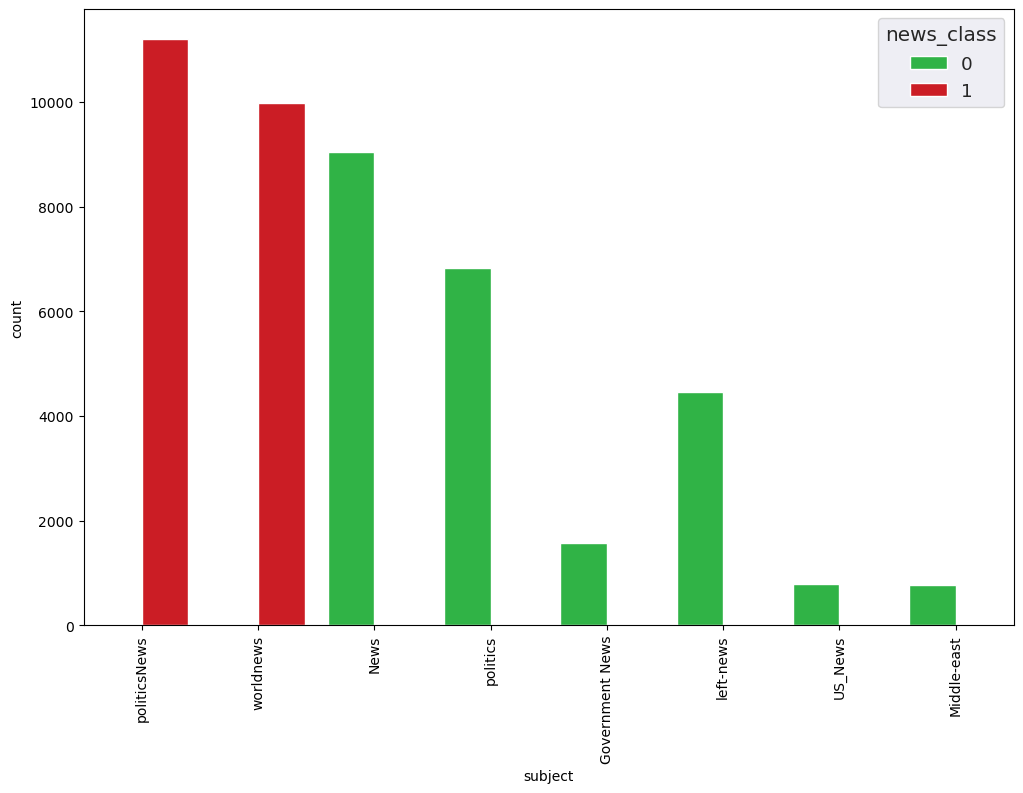

In [18]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.set_style("whitegrid")
sns.set(font_scale=1.2)
sns.countplot(x="subject", hue="news_class", data=news, ax=ax, palette=[green,red])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

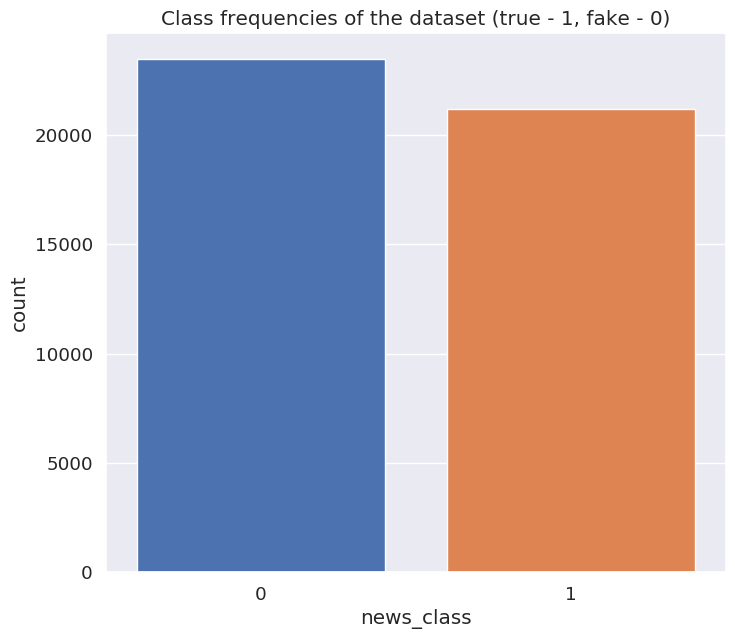

In [19]:
plt.figure(figsize = [8, 7], clear = True, facecolor = 'white')

sns.barplot(x = news["news_class"].value_counts().index,
            y = news["news_class"].value_counts(),
            saturation = 1).set(title = "Class frequencies of the dataset (true - 1, fake - 0)");

ValueError: Multi-dimensional indexing (e.g. `obj[:, None]`) is no longer supported. Convert to a numpy array before indexing instead.

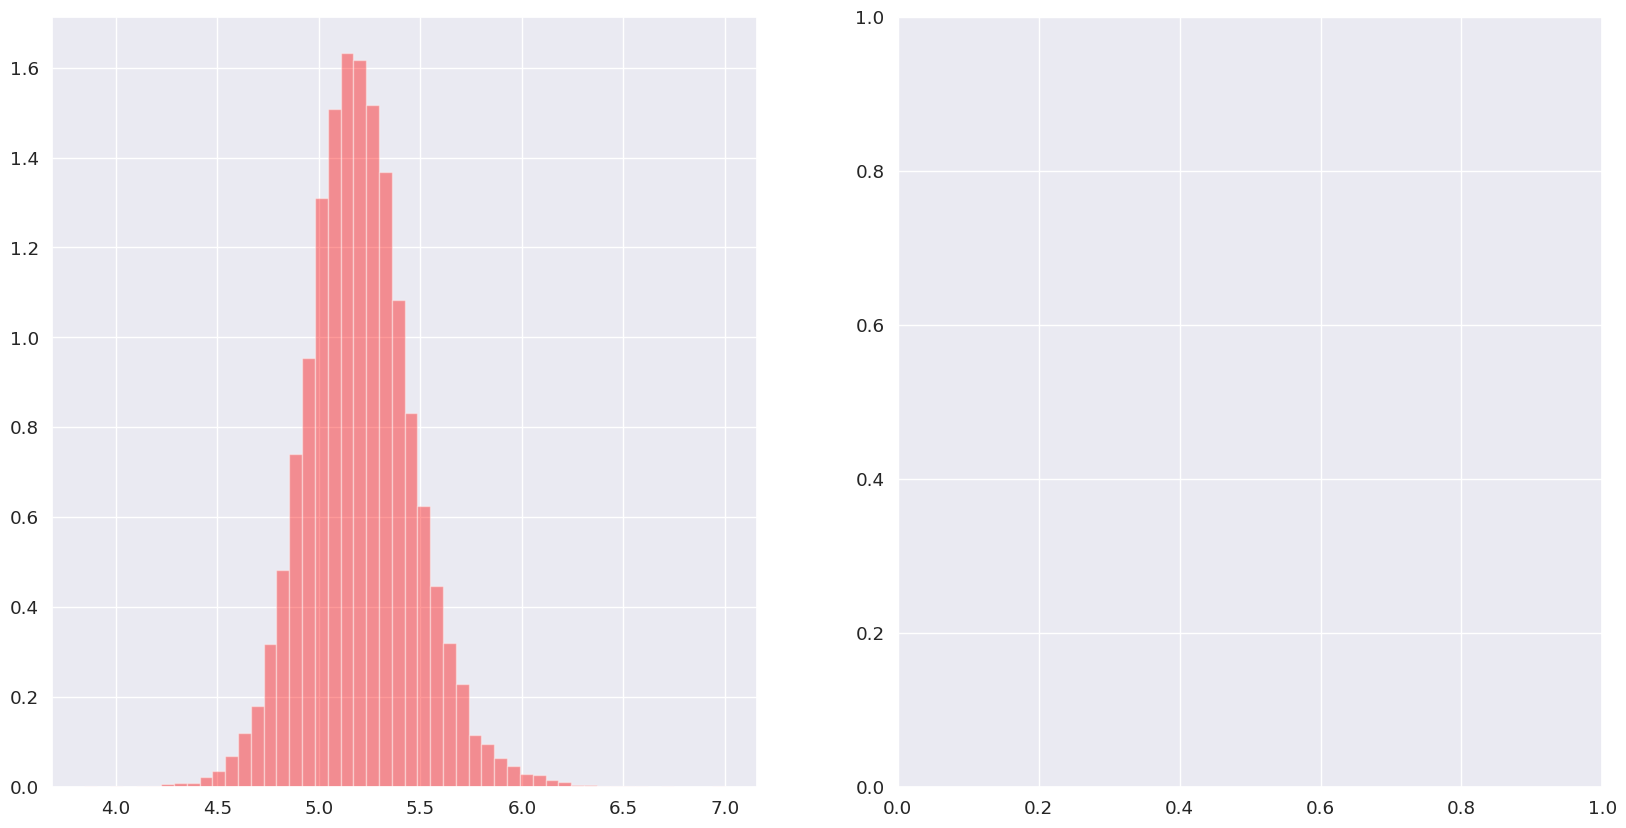

In [20]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(20,10))
word=news[news['news_class']==1]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='red')
ax1.set_title('Original text')
word=news[news['news_class']==0]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='green')
ax2.set_title('Fake text')
fig.suptitle('Average word length in each text')

In [21]:
stop_words = set(stopwords.words('english') + list(string.punctuation))

In [22]:
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

#stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def process_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation
    text = re.sub('[^\w\s]','',text)
    # Remove digits
    text = re.sub('\d', '', text)
    # Remove stop words
    text = " ".join(word for word in text.split() if word not in stop_words)
    # Lemmatize words
    text = " ".join(lemmatizer.lemmatize(word) for word in text.split())
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    return text


In [23]:
import nltk
#nltk.download('wordnet')
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

unzip:  cannot find or open /usr/share/nltk_data/corpora/wordnet.zip, /usr/share/nltk_data/corpora/wordnet.zip.zip or /usr/share/nltk_data/corpora/wordnet.zip.ZIP.


In [24]:
# Apply function on review column
news['text'] = news['text'].apply(process_text)


In [25]:
news['text'].head(5)

0    u budget fight loom republican flip fiscal scr...
1    u military accept transgender recruit monday p...
2    senior u republican senator let mr mueller job...
3    fbi russia probe helped australian diplomat ti...
4    trump want postal service charge much amazon s...
Name: text, dtype: object

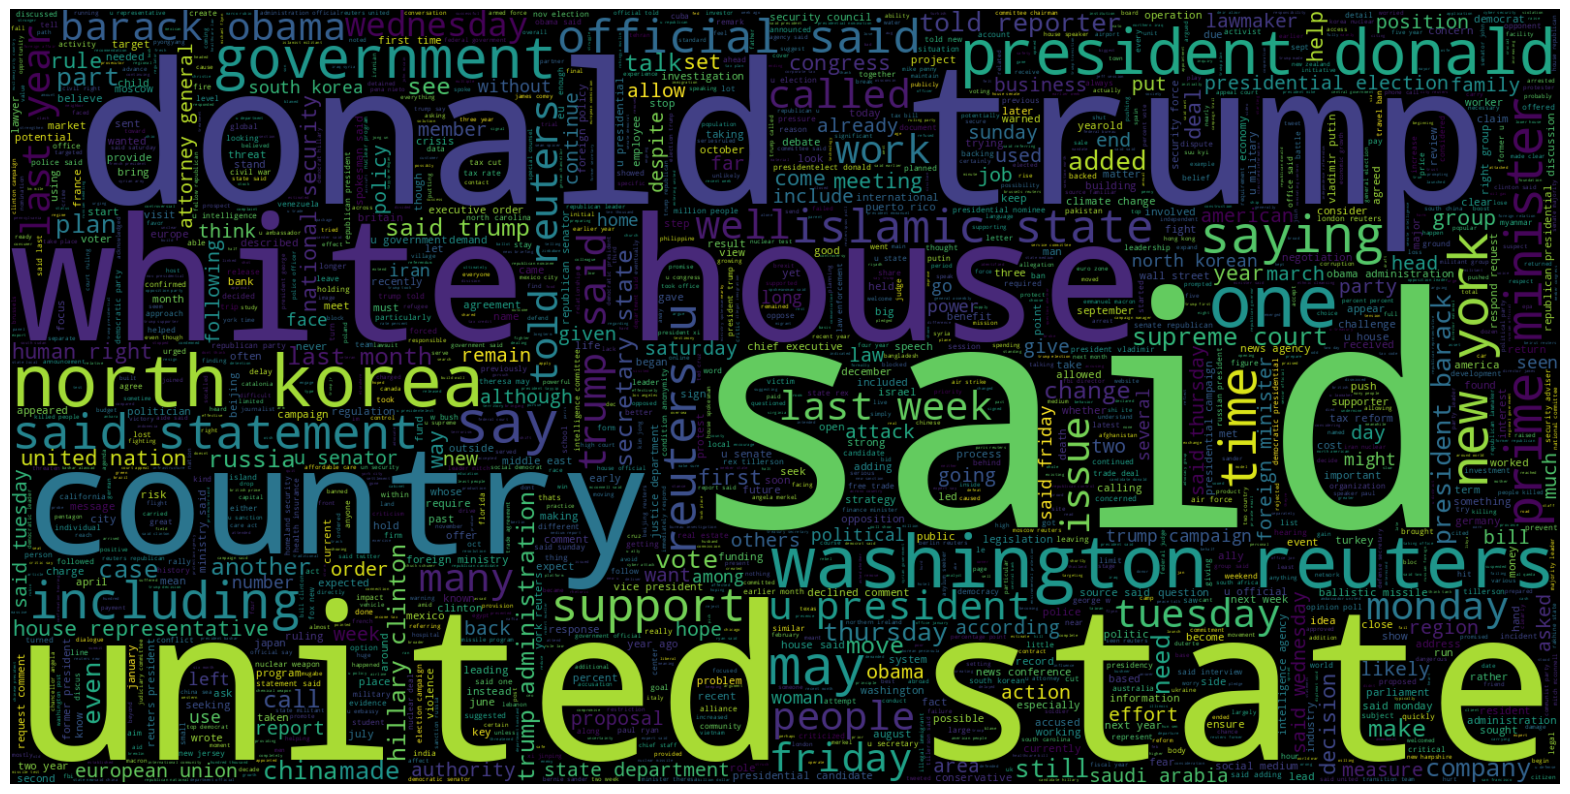

In [26]:
fig, ax = plt.subplots(figsize=(20,20)) # create a figure and axes object
text = " ".join(news[news.news_class == 1].text)
wc = WordCloud(max_words=2000, width=1600, height=800, stopwords=STOPWORDS).generate(text)
ax.imshow(wc, interpolation='bilinear') # plot the wordcloud on the axes
ax.axis('off') # turn off the axis
plt.show() # display the plot

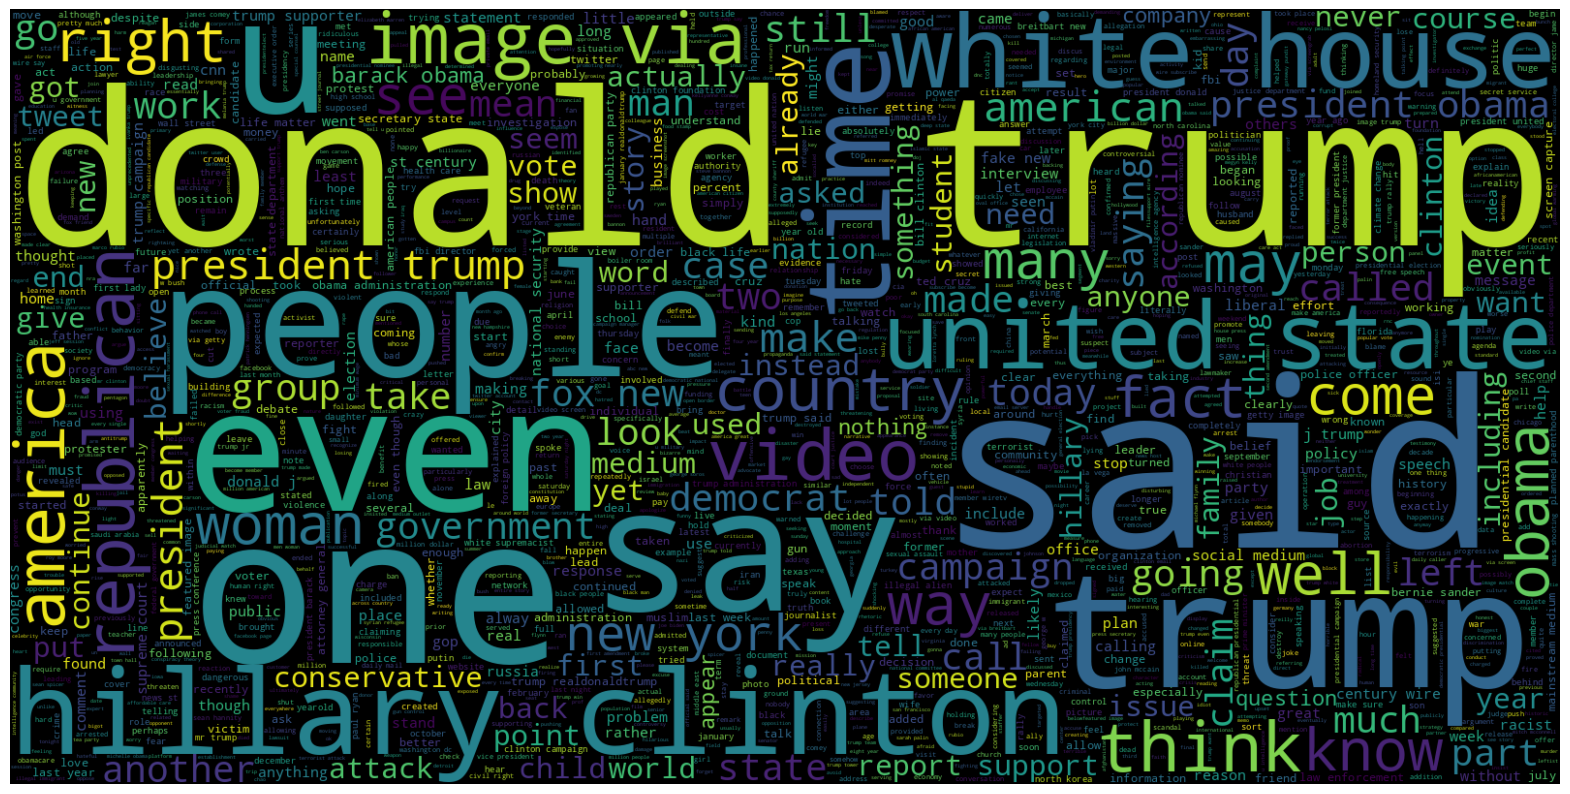

In [27]:
fig, ax = plt.subplots(figsize=(20,20)) # create a figure and axes object
text = " ".join(news[news.news_class == 0].text)
wc = WordCloud(max_words=2000, width=1600, height=800, stopwords=STOPWORDS).generate(text)
ax.imshow(wc, interpolation='bilinear') # plot the wordcloud on the axes
ax.axis('off') # turn off the axis
plt.show() # display the plot

In [28]:
def get_corpus(text):
    words = []
    for i in text:
        for j in i.split():
            words.append(j.strip())
    return words
corpus = get_corpus(news.text)
corpus[:5]

['u', 'budget', 'fight', 'loom', 'republican']

In [29]:
from collections import Counter
counter = Counter(corpus)
most_common = counter.most_common(10)
most_common = dict(most_common)
most_common

{'trump': 142078,
 'said': 129043,
 'u': 68094,
 'state': 59323,
 'would': 55064,
 'president': 54471,
 'people': 41781,
 'republican': 39831,
 'one': 37354,
 'year': 34818}

ValueError: Multi-dimensional indexing (e.g. `obj[:, None]`) is no longer supported. Convert to a numpy array before indexing instead.

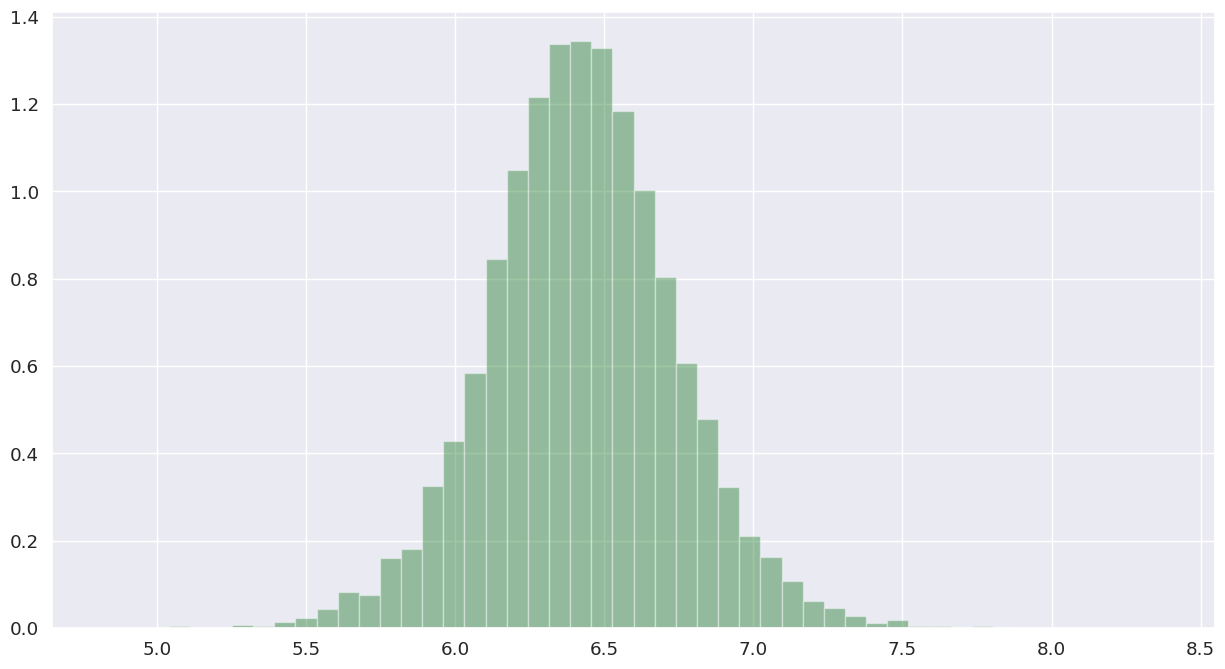

In [30]:
#average word length in true news

fig,ax = plt.subplots(figsize = (15, 8))
text_words = news[news["news_class"] == 1]["text"].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(text_words.map(lambda x: np.mean(x)), color = "#12741F", ax = ax).set_title("T R U E   N E W S");

ValueError: Multi-dimensional indexing (e.g. `obj[:, None]`) is no longer supported. Convert to a numpy array before indexing instead.

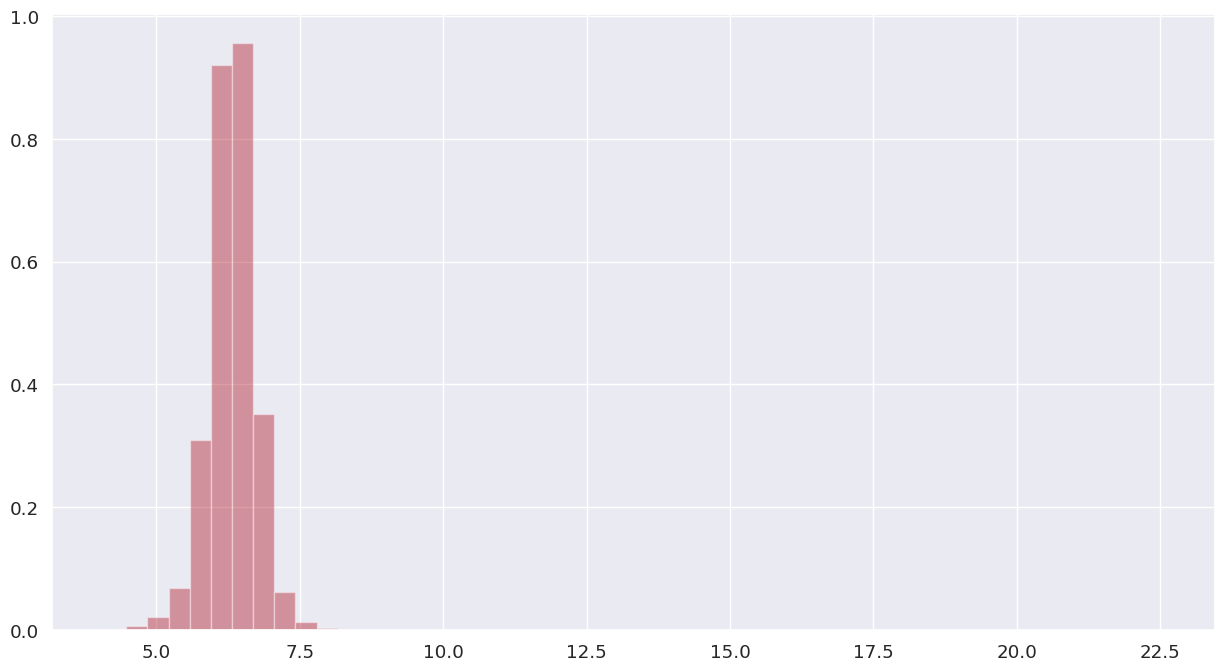

In [31]:
fig, ax = plt.subplots(figsize = (15, 8))
text_words = news[news["news_class"] == 0]["text"].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(text_words.map(lambda x: np.mean(x)), color = "#AC0C1D", ax = ax).set_title("F A K E   N E W S");

In [33]:

def get_top_text_ngrams(corpus, n, g):
    vec = CountVectorizer(ngram_range=(g, g)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [34]:
news1=news.copy(deep=True)

# Change vector

In [35]:
from sklearn.feature_extraction.text import CountVectorizer
countV = CountVectorizer(max_features = 14)
#newsCount = countV.fit_transform(news['text'].values)

In [36]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_ngram = TfidfVectorizer(stop_words='english',ngram_range=(1,2),use_idf=False,smooth_idf=False)

In [37]:
#POS Tagging
tagged_sentences = nltk.corpus.treebank.tagged_sents()

cutoff = int(.75 * len(tagged_sentences))
training_sentences = news['text']
 
print(training_sentences)

0        u budget fight loom republican flip fiscal scr...
1        u military accept transgender recruit monday p...
2        senior u republican senator let mr mueller job...
3        fbi russia probe helped australian diplomat ti...
4        trump want postal service charge much amazon s...
                               ...                        
44893    mcpain john mccain furious iran treated u sail...
44894    justice yahoo settle email privacy classaction...
44895    sunnistan u allied safe zone plan take territo...
44896    blow million al jazeera america finally call q...
44897    u navy sailor held iranian military sign neoco...
Name: text, Length: 44685, dtype: object


In [38]:
import pickle
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import  LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score


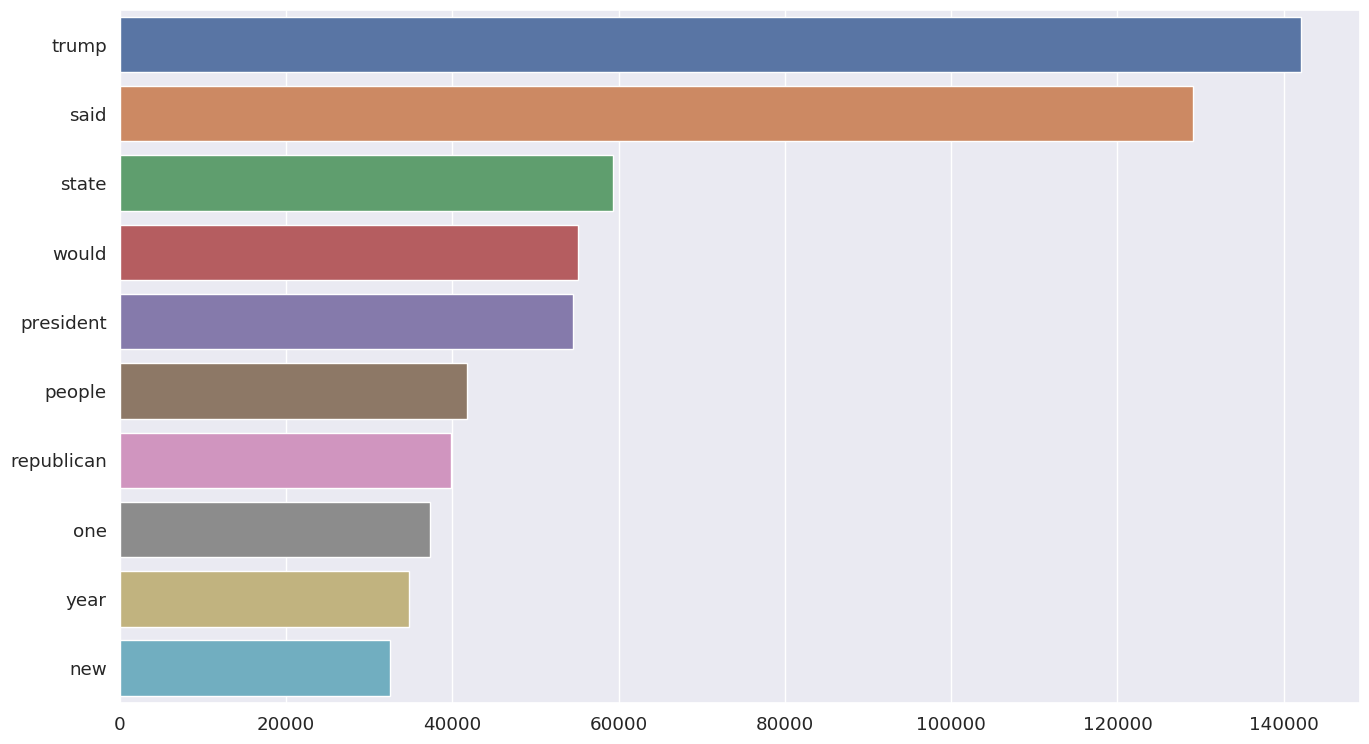

In [39]:
plt.figure(figsize = (16,9))
most_common_uni = get_top_text_ngrams(news.text,10,1)
most_common_uni = dict(most_common_uni)
sns.barplot(x=list(most_common_uni.values()),y=list(most_common_uni.keys()))

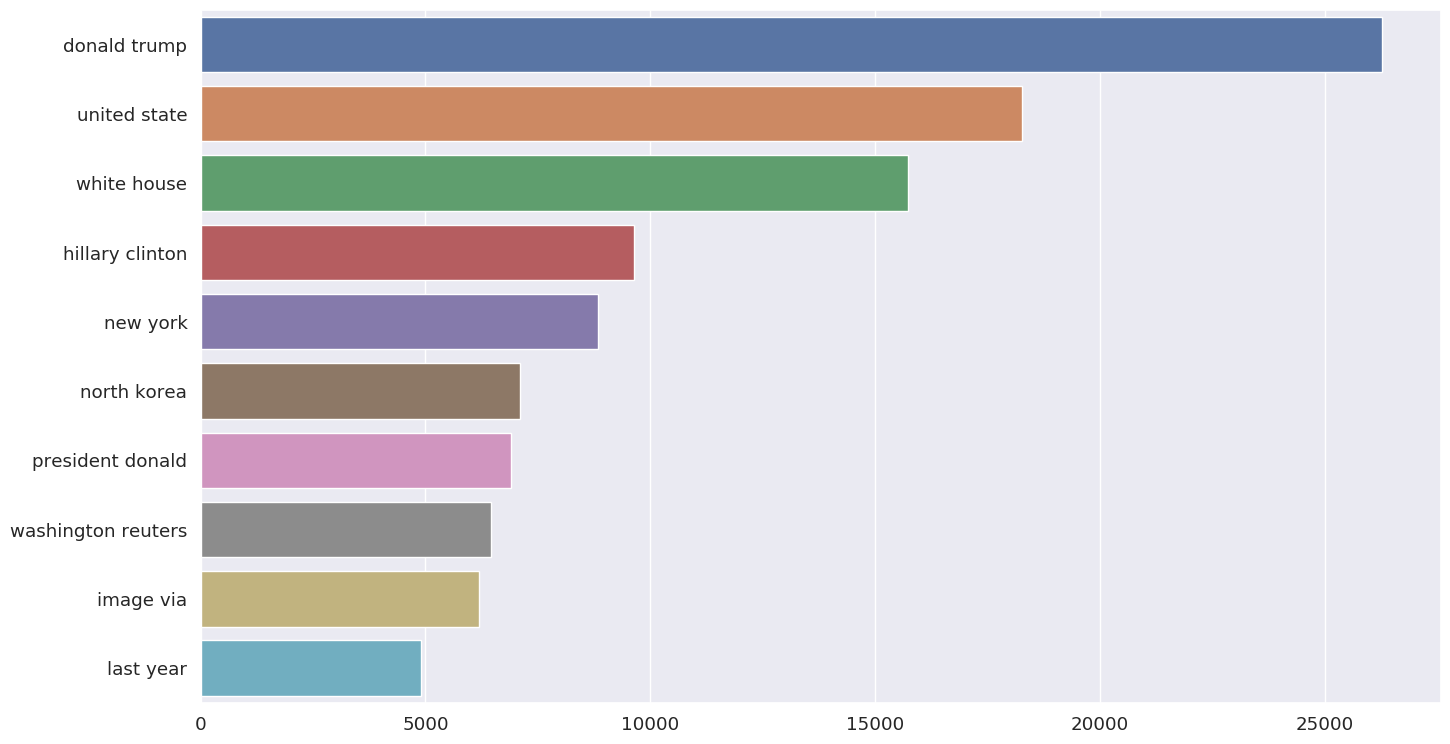

In [40]:
plt.figure(figsize = (16,9))
most_common_bi = get_top_text_ngrams(news.text,10,2)
most_common_bi = dict(most_common_bi)
sns.barplot(x=list(most_common_bi.values()),y=list(most_common_bi.keys()))

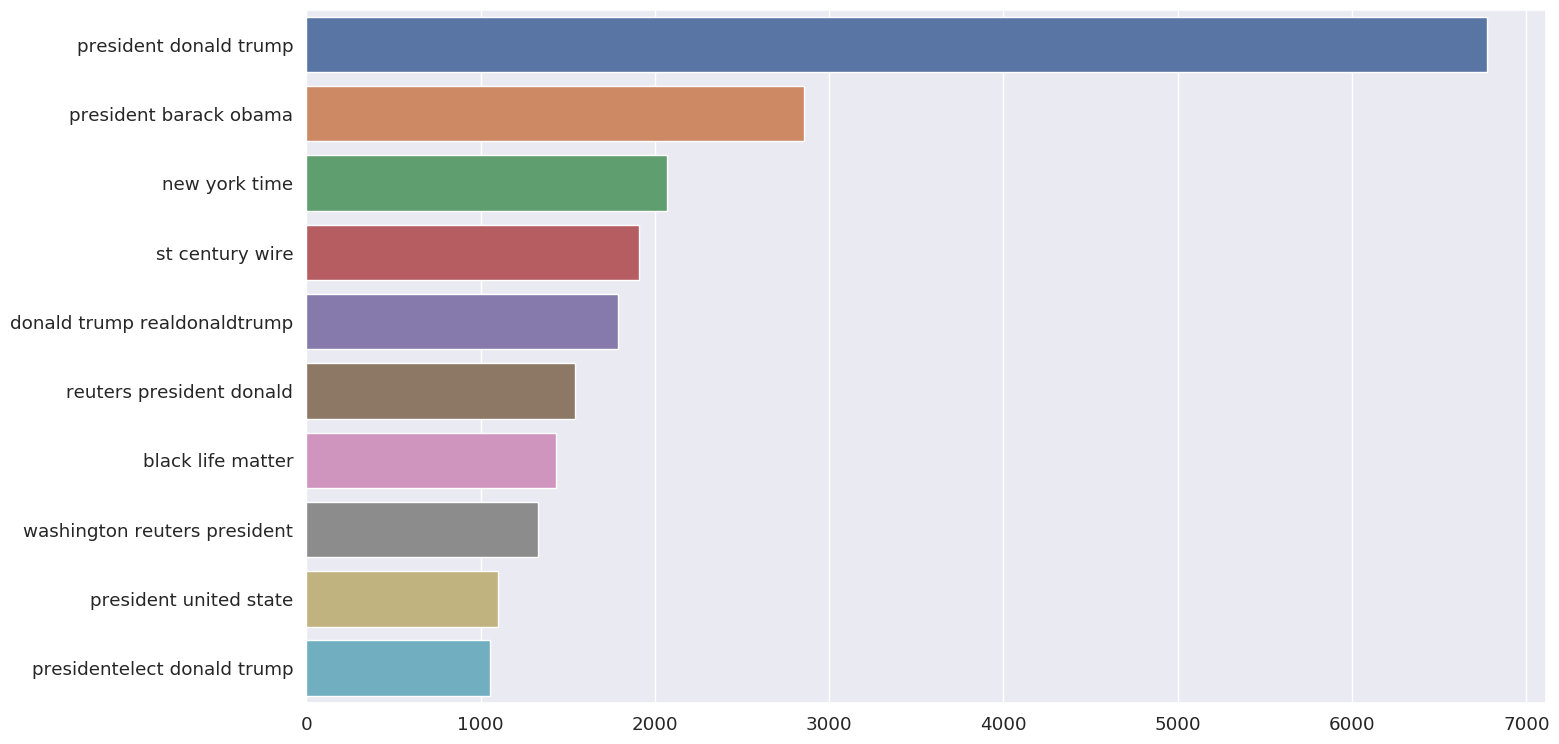

In [41]:
plt.figure(figsize = (16,9))
most_common_tri = get_top_text_ngrams(news.text,10,3)
most_common_tri = dict(most_common_tri)
sns.barplot(x=list(most_common_tri.values()),y=list(most_common_tri.keys()))

In [42]:
x_train,x_test,y_train,y_test = train_test_split(news.text,news.news_class,random_state = 34, train_size=0.70)

In [43]:
#first we will use bag of words techniques

#building classifier using naive bayes 
nb_pipeline = Pipeline([
        ('NBCV',countV),
        ('nb_clf',MultinomialNB())])


nb_pipeline.fit(x_train,y_train)
predicted_nb = nb_pipeline.predict(x_test)
np.mean(predicted_nb == y_test)

0.7959122780844398

In [44]:
#building classifier using logistic regression
logR_pipeline = Pipeline([
        ('LogRCV',countV),
        ('LogR_clf',LogisticRegression())
        ])

logR_pipeline.fit(x_train,y_train)
predicted_LogR = logR_pipeline.predict(x_test)
np.mean(predicted_LogR == y_test)


0.8078472325824257

In [45]:
print(classification_report(y_test, predicted_nb))
print(classification_report(y_test, predicted_LogR))

              precision    recall  f1-score   support

           0       0.82      0.77      0.80      6968
           1       0.77      0.82      0.79      6438

    accuracy                           0.80     13406
   macro avg       0.80      0.80      0.80     13406
weighted avg       0.80      0.80      0.80     13406

              precision    recall  f1-score   support

           0       0.79      0.86      0.82      6968
           1       0.83      0.75      0.79      6438

    accuracy                           0.81     13406
   macro avg       0.81      0.81      0.81     13406
weighted avg       0.81      0.81      0.81     13406



In [46]:
#Second we will use frequency weights with various n-grams
#building Naive Bayes Classifier with frequency weights with varioud n-grams (tf-idf)
nb_pipeline_tfidf = Pipeline([
        ('NB_TFIDF',tfidf_ngram),
        ('nb_clf',MultinomialNB())])


nb_pipeline_tfidf.fit(x_train,y_train)
predicted_nb_tfidf = nb_pipeline_tfidf.predict(x_test)
np.mean(predicted_nb_tfidf == y_test)

0.9572579442040877

In [47]:
#building classifier using logistic regression with frequency weights with varioud n-grams (tf-idf)

logR_pipeline_tfidf = Pipeline([
        ('Log_RCV',tfidf_ngram),
        ('LogR_clf',LogisticRegression())
        ])

logR_pipeline_tfidf.fit(x_train,y_train)
predicted_LogR_tfidf = logR_pipeline_tfidf.predict(x_test)
np.mean(predicted_LogR_tfidf == y_test)

0.9906758167984484

In [48]:
print(classification_report(y_test, predicted_nb_tfidf))
print(classification_report(y_test, predicted_LogR_tfidf))

              precision    recall  f1-score   support

           0       0.95      0.96      0.96      6968
           1       0.96      0.95      0.96      6438

    accuracy                           0.96     13406
   macro avg       0.96      0.96      0.96     13406
weighted avg       0.96      0.96      0.96     13406

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      6968
           1       0.99      0.99      0.99      6438

    accuracy                           0.99     13406
   macro avg       0.99      0.99      0.99     13406
weighted avg       0.99      0.99      0.99     13406



In [49]:
x_train.shape

(31279,)

In [ ]:
#Plotting learing curve
def plot_learing_curve(model,title):
    #size = 10000
    #cv = KFold(size, shuffle=True)
    
    X = x_train
    y = y_train
    
    pl = model
    pl.fit(X,y)
    
    train_sizes, train_scores, test_scores = learning_curve(pl, X, y, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5), verbose=0)
       
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
     
    plt.figure()
    plt.title(title)
    plt.legend(loc="best")
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.gca().invert_yaxis()
    
    # box-like grid
    plt.grid()
    
    # plot the std deviation as a transparent range at each training set size
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    
    # plot the average training and test score lines at each training set size
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    
    # sizes the window for readability and displays the plot
    # shows error from 0 to 1.1
    plt.ylim(-.1,1.1)
    plt.show()



# #below command will plot learing curves for each of the classifiers
plot_learing_curve(logR_pipeline_tfidf,"Naive-bayes Classifier")
plot_learing_curve(nb_pipeline_tfidf,"LogisticRegression Classifier")


In [50]:
#plotting Precision-Recall curve
def plot_PR_curve(classifier):
    
    precision, recall, thresholds = precision_recall_curve(y_test, classifier)
    average_precision = average_precision_score(y_test, classifier)
    
    plt.step(recall, precision, color='b', alpha=0.2,
             where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2,
                     color='b')
    
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Random Forest Precision-Recall curve: AP={0:0.2f}'.format(
              average_precision))
    
plot_PR_curve(logR_pipeline_tfidf)
plot_PR_curve(nb_pipeline_tfidf)


plot_PR_curve(predicted_nb)
plot_PR_curve(predicted_LogR)



TypeError: Expected sequence or array-like, got <class 'sklearn.pipeline.Pipeline'>

In [51]:
X_train,X_test,Y_train,Y_test = train_test_split(news1.text,news1.news_class,random_state = 34, train_size=0.80)
X_train.head(5)

35865    gag hollywood latino gush hillary nevada race ...
17372    least killed portugal wildfire lisbon reuters ...
40895    oops obama tell troop foreign terror attack ha...
36362    breaking bad news hillary fbi expanding invest...
5347     democrat member fec make early exit nyt washin...
Name: text, dtype: object

In [52]:
from keras.utils import pad_sequences
max_features = 10000
maxlen = 300
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(X_train)

tokenized_X_train = tokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(tokenized_X_train, maxlen=maxlen)
X_train

array([[   0,    0,    0, ...,  489,  520, 1956],
       [   0,    0,    0, ..., 2388, 8122, 8772],
       [  58,  223,  519, ..., 2263,  520,  513],
       ...,
       [   0, 1454,  969, ...,  288,   78, 2274],
       [ 262, 1240,   29, ...,  278, 3643,  100],
       [   0,    0,    0, ..., 3157, 2543,   10]], dtype=int32)

In [53]:
tokenized_X_test = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(tokenized_X_test, maxlen=maxlen)

In [54]:
EMBEDDING_FILE = "glove.twitter.27B.100d.txt"

In [55]:
def get_coefs(word, *arr): 
    return word, np.asarray(arr, dtype="float32")

embeddings_index = dict(get_coefs(*x.rstrip().rsplit(" ")) for x in open(EMBEDDING_FILE))

In [56]:
all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))

#change below line if computing normal stats is too slow
embedding_matrix = embedding_matrix = np.random.normal(emb_mean,
                                                       emb_std,
                                                       (nb_words, embed_size))

for word, i in word_index.items():
    if i >= max_features:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [82]:
learning_rate_reduction = ReduceLROnPlateau(monitor="val_accuracy",
                                            patience = 2,
                                            verbose=1,
                                            factor=0.4,
                                            min_lr=0.00001)

In [83]:
#Defining Neural Network
model = Sequential()

#Non-trainable embeddidng layer
model.add(Embedding(max_features,
                    output_dim=embed_size,
                    weights=[embedding_matrix],
                    input_length=maxlen,
                    trainable=False))

#LSTM 
#model.add(LSTM(units=128, return_sequences = True, recurrent_dropout = 0.3, dropout = 0.3))
model.add(LSTM(units=64, recurrent_dropout = 0.7, dropout = 0.7))
model.add(Dense(units = 32, activation = 'relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=keras.optimizers.Adam(lr = 0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [84]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 300, 100)          1000000   
                                                                 
 lstm_1 (LSTM)               (None, 64)                42240     
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,044,353
Trainable params: 44,353
Non-trainable params: 1,000,000
_________________________________________________________________


In [85]:
batch_size = 1024
epochs = 10
history = model.fit(X_train,
                    Y_train,
                    batch_size=batch_size,
                    validation_data=(X_test,Y_test),
                    epochs=epochs,
                    callbacks=[learning_rate_reduction])

Epoch 1/10
35/35 [==============================] - 10s 273ms/step - loss: 0.5016 - accuracy: 0.7553 - val_loss: 0.3712 - val_accuracy: 0.8613 - lr: 0.0010
Epoch 2/10
35/35 [==============================] - 9s 265ms/step - loss: 0.2921 - accuracy: 0.8801 - val_loss: 0.3194 - val_accuracy: 0.8690 - lr: 0.0010
Epoch 3/10
35/35 [==============================] - 9s 264ms/step - loss: 0.2305 - accuracy: 0.9100 - val_loss: 0.1942 - val_accuracy: 0.9179 - lr: 0.0010
Epoch 4/10
35/35 [==============================] - 9s 265ms/step - loss: 0.2371 - accuracy: 0.9036 - val_loss: 0.2755 - val_accuracy: 0.8874 - lr: 0.0010
Epoch 5/10
35/35 [==============================] - 9s 261ms/step - loss: 0.2278 - accuracy: 0.9139 - val_loss: 0.1604 - val_accuracy: 0.9429 - lr: 0.0010
Epoch 6/10
35/35 [==============================] - 9s 265ms/step - loss: 0.1931 - accuracy: 0.9301 - val_loss: 0.1813 - val_accuracy: 0.9304 - lr: 0.0010
Epoch 7/10
35/35 [==============================] - 9s 269ms/step - l

In [86]:
print("Accuracy of the model on Training Data is:", model.evaluate(X_train,Y_train)[1]*100, "%")
print("Accuracy of the model on Testing Data is:", model.evaluate(X_test,Y_test)[1]*100, "%")

1118/1118 [==============================] - 35s 31ms/step - loss: 0.1317 - accuracy: 0.9543
Accuracy of the model on Training Data is: 95.43191194534302 %
280/280 [==============================] - 9s 31ms/step - loss: 0.1369 - accuracy: 0.9527
Accuracy of the model on Testing Data is: 95.26686668395996 %


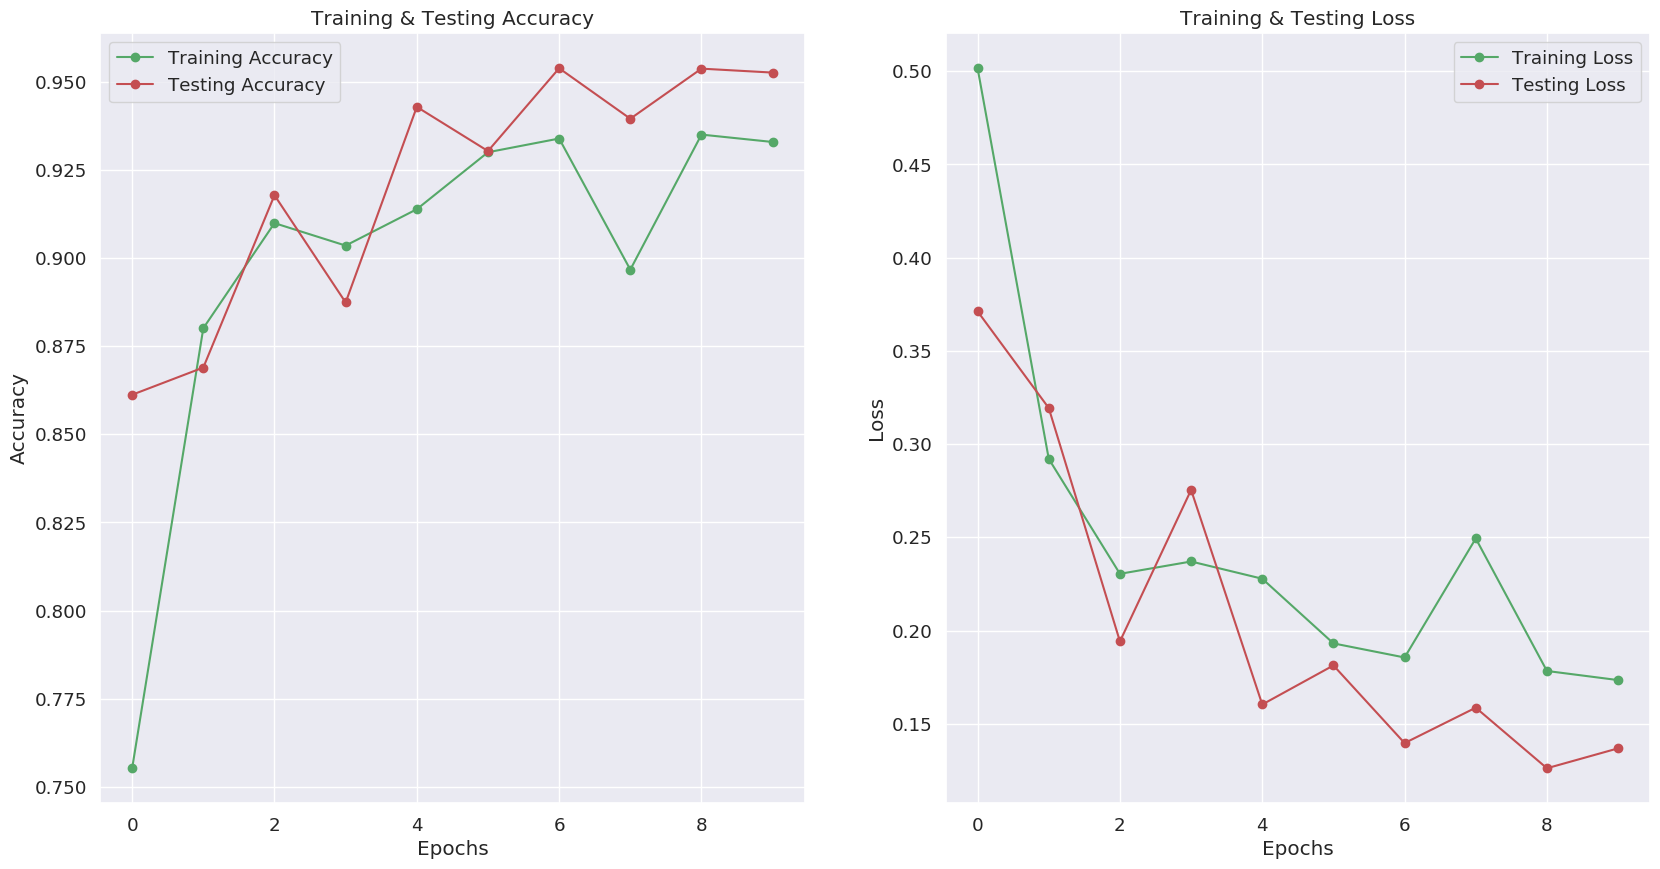

In [87]:
epochs = [i for i in range(10)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Testing Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'go-' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'ro-' , label = 'Testing Loss')
ax[1].set_title('Training & Testing Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

In [88]:
y_ped_t = model.predict(X_test)

280/280 [==============================] - 8s 30ms/step


In [89]:
ypred=np.round(y_ped_t)
ls= list()
for i in range(len(ypred)):
    ls.append(int(ypred[i].item()))



In [90]:
y_ped_t

array([[0.02308716],
       [0.9879062 ],
       [0.99605465],
       ...,
       [0.9920278 ],
       [0.9922212 ],
       [0.99252135]], dtype=float32)

In [91]:
sum(Y_test), sum(ls)

(4318, 4159)

In [92]:
print(classification_report(Y_test, ls, target_names = ['Fake','Not Fake']))

              precision    recall  f1-score   support

        Fake       0.94      0.97      0.95      4619
    Not Fake       0.97      0.93      0.95      4318

    accuracy                           0.95      8937
   macro avg       0.95      0.95      0.95      8937
weighted avg       0.95      0.95      0.95      8937



In [93]:
cm = confusion_matrix(Y_test, ls)
cm

array([[4487,  132],
       [ 291, 4027]])

In [94]:
cm = pd.DataFrame(cm , index = ['Fake','Original'] , columns = ['Fake','Original'])

Text(88.25, 0.5, 'Actual')

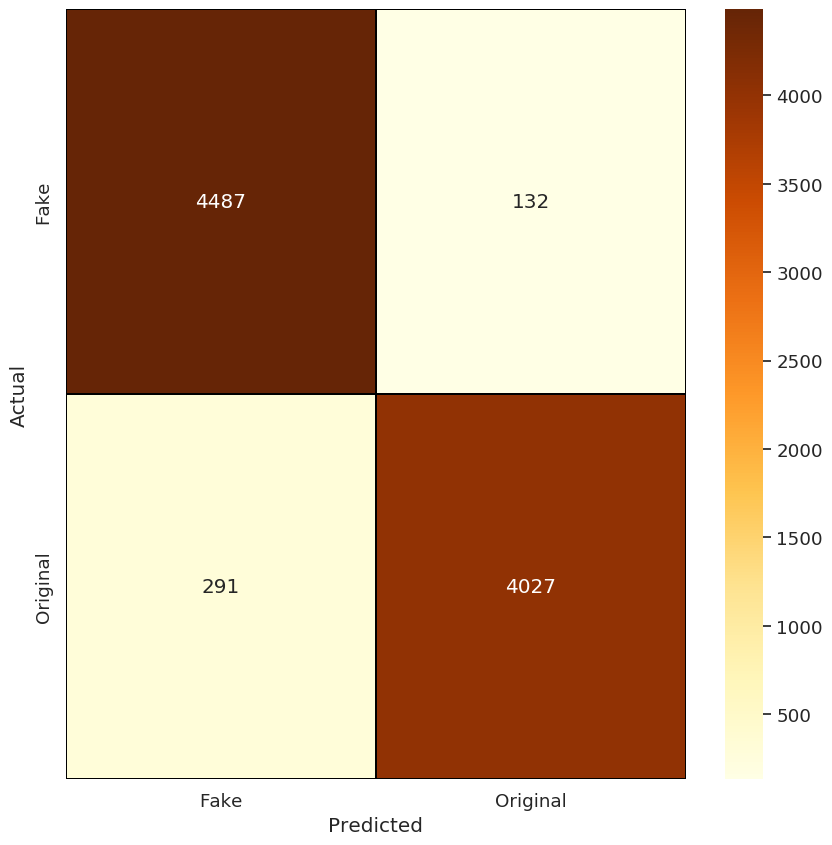

In [95]:
plt.figure(figsize = (10,10))

sns.heatmap(cm,
            linecolor='black',
            cmap="YlOrBr",
            linewidth=1,
            annot=True,
            fmt="",
            xticklabels=['Fake','Original'],
            yticklabels=['Fake','Original'])

plt.xlabel("Predicted")
plt.ylabel("Actual")

In [96]:
def AUC_ROC_plot(Y_test, ls):    
    ref = [0 for _ in range(len(Y_test))]
    ref_auc = roc_auc_score(Y_test, ref)
    lr_auc = roc_auc_score(Y_test, ls)

    ns_fpr, ns_tpr, _ = roc_curve(Y_test, ref)
    lr_fpr, lr_tpr, _ = roc_curve(Y_test, ls)

    plt.plot(ns_fpr, ns_tpr, linestyle='--')
    plt.plot(lr_fpr, lr_tpr, marker='.', label='AUC = {}'.format(round(roc_auc_score(Y_test, ls)*100,2))) 
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

In [97]:
y_ped_t.shape

(8937, 1)

In [98]:
t = y_ped_t
te = np.zeros((len(y_ped_t), 1,2))
for i in range(len(y_ped_t)):
    te[i][0][0] = y_ped_t[i].item()
    te[i][0][1] = 1 - y_ped_t[i].item()
    


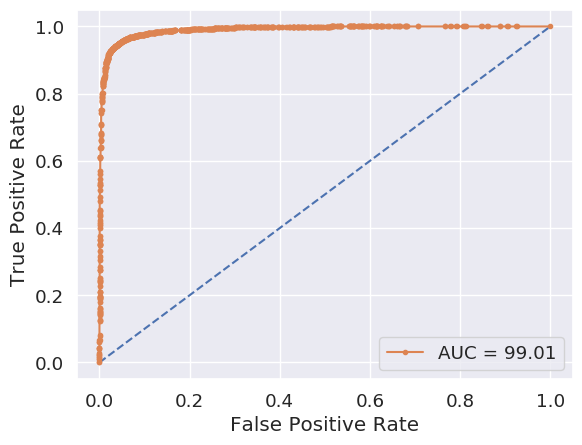

In [99]:

from sklearn.metrics import roc_auc_score, roc_curve
from scikitplot.metrics import plot_roc_curve as auc_roc
AUC_ROC_plot(Y_test, y_ped_t)
plt.show()

In [77]:
r_t = model.predict(X_test1)

NameError: name 'X_test1' is not defined

In [ ]:
r_t

In [ ]:
X_train1,X_test1,Y_train1,Y_test1 = train_test_split(news1.text,news1.news_class,random_state = 34, train_size=0.80)
X_train1.shape


('Mexican president backs U.S. dollar as globes principal currency (Reuters) MEXICO CITY, May 8 (Reuters) - Mexican President Andres Manuel Lopez Obrador gave the U.S. dollar a vote on confidence on Monday after he was asked if a weakening greenback might spur a move to diversify Mexicos foreign currency reserves. We are going to continue considering the dollar as the worlds principal currency, Lopez Obrador told a press conference. We have sufficient reasons to not move to other currencies, he said, underscoring Mexicos increasingly close economic ties to the United States. The United States is by far Mexicos largest trading partner, with both economies closely integrated over decades in sectors ranging from energy, autos and agriculture. The dollar remained weaker against most of its major peers on Monday as fears persist about a potential recession in the United States later this year. Asked if he would recommend that the central bank diversify Mexicos foreign currency reserves, Lop

In [ ]:
news1['news_class'][0]

In [79]:


X_tst.shape


(1,)

In [80]:

X_tst.shape

(1, 300)

In [81]:
article = 'Mexican president backs U.S. dollar as globes principal currency (Reuters) MEXICO CITY, May 8 (Reuters) - Mexican President Andres Manuel Lopez Obrador gave the U.S. dollar a vote on confidence on Monday after he was asked if a weakening greenback might spur a move to diversify Mexicos foreign currency reserves. We are going to continue considering the dollar as the worlds principal currency, Lopez Obrador told a press conference. We have sufficient reasons to not move to other currencies, he said, underscoring Mexicos increasingly close economic ties to the United States. The United States is by far Mexicos largest trading partner, with both economies closely integrated over decades in sectors ranging from energy, autos and agriculture. The dollar remained weaker against most of its major peers on Monday as fears persist about a potential recession in the United States later this year. Asked if he would recommend that the central bank diversify Mexicos foreign currency reserves, Lopez Obrador said that even with a financial crisis in the future, the dollar would continue to be the most important currency in the world. Despite concerns over recession, positive economic indicators helped push Mexicos peso on Friday to its strongest level against the dollar since 2017. The Mexican presidents remarks follow comments from Brazils President Luiz Inacio Lula da Silva, a fellow leftist, in which he expressed support for an alternative to the U.S. dollar for trade in certain circumstances including within South America.'
preprocessed_article = list()
preprocessed_article.append(process_text(article) )
arr_article = np.array(preprocessed_article)
tokenized_article = tokenizer.texts_to_sequences(arr_article)
final_article = pad_sequences(tokenized_article, maxlen=maxlen)
result= model.predict(final_article)
result

1/1 [==============================] - 0s 39ms/step


array([[0.9864703]], dtype=float32)